In [1]:
import apriltag
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from utils import *

In [2]:
# 场地内测的边长约为294cm x 294cm；内部：
# - 地面上分布有ID为20~42的tag
# - 障碍物上分布有ID为43~71的tag

def load_tag_pos():
    M = 294.1
    def expand(LL):
        LL.append(0)
        a = np.array([
            [0, 0, 0], [5, 0, 0], [5, 5, 0], [0, 5, 0]
        ])
        return a + np.array(LL)
    
    def expand2(LL, face):
        x_dir_LUT = {
            "x": [0,1,0],
            "y": [-1,0,0],
            "-x": [0,-1,0],
            "-y": [1,0,0]
        }
        x_dir = x_dir_LUT[face]
        LL.append(0)
        h = np.array([0,0,-35])
        y = np.array([0, 0, -5])
        x = np.array(x_dir) * 5
        a = np.array([
            np.zeros(3), x, x + y, y
        ]) + h
        return a + np.array(LL)

    tag_poses = {}
    tag_poses['20'] = expand([0.9, 1.2])
    tag_poses['21'] = expand([1.75, 94])
    tag_poses['22'] = expand([1.6, 194.1])
    tag_poses['23'] = expand([0.8, 288.0])
    tag_poses['24'] = expand([94.8, 1.6])
    tag_poses['25'] = expand([92.5, 93.2])
    tag_poses['27'] = expand([94.7, M-5.8])
    tag_poses['28'] = expand([195.0, 1.2])
    tag_poses['29'] = expand([191.6, 92.7])
    tag_poses['30'] = expand([193.6, M-98.0])
    tag_poses['31'] = expand([194.9, M-6.6])
    tag_poses['32'] = expand([M-6, 1.9])
    tag_poses['33'] = expand([M-6.6, M-99.9])
    tag_poses['34'] = expand([M-6, M-6.3])
    tag_poses['35'] = expand([93.6, 47.7])
    tag_poses['36'] = expand([67.3, 174.7])
    tag_poses['37'] = expand([143.3, 156.6])
    tag_poses['38'] = expand([140.4, M-51.4])
    tag_poses['39'] = expand([238.6, M-54.0])
    tag_poses['40'] = expand([235.9, 136.7])
    tag_poses['41'] = expand([238.8, 52.6])
    tag_poses['42'] = expand([52.9, M-53.0])


    tag_poses['43'] = expand2([24.22 + 25, 35.7], 'x')
    tag_poses['44'] = expand2([24.22 + 25, 35.7 + 25], 'y')
    tag_poses['45'] = expand2([59, 112], '-y')
    tag_poses['46'] = expand2([59 + 25, 112], 'x')
    tag_poses['47'] = expand2([59 + 25, 112 + 25], 'y')
    tag_poses['48'] = expand2([59, 112 + 25], '-x')
    tag_poses['49'] = expand2([90.7, M-70.6-25], '-y')
    tag_poses['50'] = expand2([90.7 + 25, M-70.6-25], 'x')
    tag_poses['51'] = expand2([90.7 + 25, M-70.6], 'y')
    tag_poses['52'] = expand2([90.7, M-70.6], '-x')
    tag_poses['53'] = expand2([7.0, M-48 - 25], '-y')
    tag_poses['54'] = expand2([7.0 + 25, M-48 - 25], 'x')
    tag_poses['55'] = expand2([M-85.1-25, 113], '-y')
    tag_poses['56'] = expand2([M-85.1-25, 113+25], '-x')
    tag_poses['57'] = expand2([M-85.1, 113+25], 'y')
    tag_poses['58'] = expand2([M-85.1, 113], 'x')
    tag_poses['59'] = expand2([M-9.1-25, 73.2], '-y')
    tag_poses['60'] = expand2([M-9.1-25, 73.2+25], '-x')
    tag_poses['61'] = expand2([M-9.1, 73.2+25], 'y')
    tag_poses['62'] = expand2([M-6.6-25, M-126.3], '-x')
    tag_poses['63'] = expand2([M-6.6, M-126.3], 'y')
    tag_poses['64'] = expand2([M-6.6-25, M-126.3-25], '-y')
    tag_poses['65'] = expand2([M-62-25, M-17.6-25], '-y')
    tag_poses['66'] = expand2([M-62-25, M-17.6], '-x')
    # tag_poses['67'] = expand2([M-62, M-17.6], 'x')
    tag_poses['67'] = expand2([M-62, M-17.6], 'y')
    tag_poses['68'] = expand2([7.0 + 25, M-48], 'y')
    tag_poses['69'] = expand2([M-114-25, 30.3 + 25], '-x')
    tag_poses['70'] = expand2([M-114, 30.3 + 25], 'y')
    # tag_poses['71'] = expand2([M-114, 30.3], 'y')
    tag_poses['71'] = expand2([M-114, 30.3], 'x')
    return tag_poses


# 给选手提供的用于路径规划的数据：
# - [X_min, X_max], [Y_min, Y_max]为场地在x和y两个方向的边界（单位：cm）
# - obstacles为所有障碍物的四个顶脚的平面坐标（单位：cm）

X_min, X_max = 0, 294.1
Y_min, Y_max = 0, 294.1
        
obstacles = [[[24.22, 35.75], [48.22, 35.75], [48.22, 59.75], [24.22, 59.75]], 
             [[59, 112], [83, 112], [83, 136], [59, 136]], 
             [[156.2, 30.3], [180.2, 30.3], [180.2, 54.3], [156.2, 54.3]], 
             [[261.1, 73.2], [285.1, 73.2], [285.1, 97.2], [261.1, 97.2]], 
             [[185.1, 113], [209.1, 113], [209.1, 137], [185.1, 137]], 
             [[263.6, 143.9], [287.6, 143.9], [287.6, 167.9], [263.6, 167.9]], 
             [[90.7, 199.6], [114.7, 199.6], [114.7, 223.6], [90.7, 223.6]], 
             [[7, 222.2], [31, 222.2], [31, 246.2], [7, 246.2]], 
             [[208.2, 252.6], [232.2, 252.6], [232.2, 276.6], [208.2, 276.6]],
             [[180.9, 204.2], [207.2, 204.2], [207.2, 214.2], [180.9, 214.2]]]
pos = load_tag_pos() 
print(pos['60'])

[[ 260.    98.2  -35. ]
 [ 260.    93.2  -35. ]
 [ 260.    93.2  -40. ]
 [ 260.    98.2  -40. ]]


In [3]:
# 更新img图像的函数
def updateImage():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


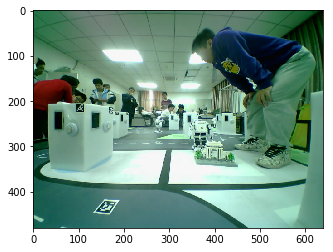

In [4]:
img = updateImage()
plt.imshow(img)

In [24]:
# function 1 计算Y方向的机器人世界坐标y_rob

def XY_Robot():
    # 实例化检测器并检测Apriltag
    img = updateImage()
    img = np.array(img)
#     img = cv2.imread('1.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)
#     print(tags)
    cnt = 0
    while len(tags) == 0 and cnt < 5:
        img = updateImage()
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        tags = detector.detect(gray)
        cnt += 1
        if cnt == 5:
            run_action('turn003L')
            wait_req()
            cnt = 0
    
        
#     print(tags)
    # 获取pos和corners的代码
    tag_positions = load_tag_pos() 

    # 获取pos和corners的代码
    tag_num = len(tags)
    for n, tag in enumerate(tags):
#         print("debug here::",tag.tag_id)
#         if tag.tag_id > 41:
#             continue
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        pos = tag_positions[str(tag.tag_id)]
#         print(pos)
        # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
        corners = np.array(tag.corners)
#         print(corners)
    # 2D坐标
    ImgPoints = corners
    # 3D坐标
    WorldPoints = pos
    # 内参矩阵
    fx = 192.0513
    fy = 194.1294
    cx = 311.9018
    cy = 233.6934
    intrinsic_matrix =  np.array([[fx,0,cx],
                              [0,fy,cy],
                              [0,0,1]],dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.2683,-0.2053,0,0])
    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints,ImgPoints,intrinsic_matrix,distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    # R矩阵的第三行
    direction = np.matrix(rotM)[2]
    #
    # print("朝向::",direction)
    x_robot = cameraPosition[0]
    y_robot = cameraPosition[1]
    
    dirXY = direction[:,:2]
    normdir = dirXY / np.linalg.norm(dirXY)
    
    return y_robot,x_robot,normdir

In [44]:
Y,X,direction = XY_Robot()
print("Robot的Y坐标为:",Y)
print("Robot的X坐标为:",X)
print("朝向为:",direction)
theta = angle(direction)
print("角度为:",theta)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Robot的Y坐标为: [[ 108.2597944]]
Robot的X坐标为: [[ 241.22255874]]
朝向为: [[ 0.06817141  0.99767362]]
角度为: [[ 86.0935731]]


In [40]:
# 写一个固定转角的函数
def rotate_to_balance(zero):
    '''
    input:
    zero,角度的基准
    output:
    None.将机器人转为X轴正方向
    '''
    _,_,dirs= XY_Robot()
    theta = angle(dirs)

    # 设置一个物理上的零点,可供机器人调参数
    distance = theta - zero

    # 设定阈值位5度
    while abs(distance) > 5:
        if distance > 0:
            run_action('turn001L')
        if distance < 0:
            run_action('turn001R')
        _,_,dirs= XY_Robot()
        theta = angle(dirs)
        distance = theta - zero
        print("Adjusting angle: theta=",theta)

    # 最后再微调一下
    if distance > 0.5:
        run_action('turn001L')
    if distance < -0.5:
        run_action('turn001R')
    print("Adjusting angle: theta=",theta)
    return 0

In [39]:
def refineY_to_balance(y_target, threshold=5):
    """Adjust y coordinate of the robot."""
    y_robot,_,_ = XY_Robot()
    distance = y_robot - y_target
    print("Adjusting Y: y_robot=", y_robot)
    print("Adjusting Y: y_target=", y_target)
    while abs(distance) > threshold:
        if distance > 0:
            run_action('Left02move') 
        else:
            run_action('Right02move')
        y_robot,_ ,_= XY_Robot()
        distance = y_robot - y_target
        print("Adjusting Y: y_robot=", y_robot)
        print("Adjusting Y: y_target=", y_target)
    
    return 0

def refineX_to_balance(x_target, threshold=5):
    """Adjust x coordinate of the robot."""
    _,x_robot,_ = XY_Robot()
    distance = x_robot - x_target
    print("Adjusting X: x_robot=", x_robot)
    print("Adjusting X: x_target=", x_target)
    while abs(distance) > threshold:
        if distance > 0: # 后退
            run_action('Back2Run')
        else: # 前进
            run_action('Forwalk02') 
        y_robot,_ ,_= XY_Robot()
        distance = x_robot - x_target
        print("Adjusting X: x_robot=", x_robot)
        print("Adjusting X: x_target=", x_target)
    
    return 0

In [9]:
# 归一化向量并计算角度
print(dir)
dirXY = dir[:,:2]
normdir = dirXY / np.linalg.norm(dirXY)
print(normdir)


<built-in function dir>


TypeError: 'builtin_function_or_method' object is not subscriptable

In [47]:
#TODO:冲到按钮的固定位置处并撞击按钮
def rush(y_target):
    # 一鼓作气冲到按钮的位置,实际上可以加入微调的模块
    run_action('fastForward03')
    # 调整Y的位置至最后冲刺按钮的位置
    refineY_to_balance(y_target)
    wait_req()
    rotate_to_balance(0)
    wait_req()
    # 冲向按钮撞击按钮
    print('冲啊！！！')

#     refineY_to_balance(y_target)
#     wait_req()
#     rotate_to_balance(0)
#     wait_req()
    run_action('fastForward05')
    return 0

In [ ]:
run_action('turn010R')
wait_req()
run_action('turn010R')
wait_req()


for i in range(37):
    run_action('Left3move')
    wait_req()


refineY_to_balance(85)
rotate_to_balance(0)


# assert 1==0
# run_action('Forwalk02')
# wait_req()
# run_action('turn002L')
# wait_req()

# for i in range(4):
#     run_action('Forwalk02')
#     wait_req()
#     run_action('turn001L')
#     wait_req()

y,x,_ = XY_Robot()
print("X=",x)
while x < 194:
    run_action('Forwalk02')
    wait_req()
    run_action('turn001L')
    wait_req()
#     run_action('Forwalk02')
#     wait_req()
#     run_action('turn001L')
#     wait_req()
    
    y,x,_ = XY_Robot()
    print("X=",x)

refineY_to_balance(85, threshold=6)
rotate_to_balance(0)    
# refineX_to_balance(200, threshold=7.5)

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
t

read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'


read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'


read REQ finished!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processin

Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 3

Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting Y: y_robot= [[ 99.54770665]]
Adjusting Y: y_target= 85
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\

Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
X= [[ 319.0782074]]
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting Y: y_robot= [[ 834.13231011]]
Adjusting Y: y_target= 85
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying so

Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_r

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting Y: y_robot= [[ 82.38647596]]
Adjusting Y: y_target= 85
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xili

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-37.72091563]]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
te

--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying sour

Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-20.0282393]]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-34.16666041]]
test_read b'\xff'
test_read b'\xff'
test_

Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting angle: theta= [[-26.47677928]]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384

In [46]:
rush(87)

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyte

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyte

Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Adjusting Y: y_robot= [[ 55.71458952]]
Adjusting Y: y_target= 85
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x

0